# Exercise 21: CNN in PyTorch

PyTorch and other libraries like it use the concept of a TENSOR (multidimensional array of data) to store data
and weights and biases and other things too.

Let's implement a simple CNN in PyTorch. We will try to classify the MNIST handwritten digits dataset.

In [8]:
pip install python-mnist

Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
import torchvision
import os

import os

os.environ["http_proxy"] = 'http://192.41.170.23:3128'
os.environ["https_proxy"] = 'http://192.41.170.23:3128'

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

mnist_train = torchvision.datasets.MNIST('./data', train=True, transform=transform)
mnist_val = torchvision.datasets.MNIST('./data', train=False, transform=transform)

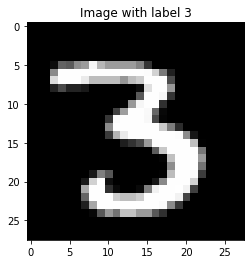

In [10]:
import matplotlib.pyplot as plt

img = mnist_train[12][0]
label = mnist_train[12][1]
plt.imshow(img.reshape(28, 28), cmap='gray')
plt.title('Image with label %d' % (label))
plt.show()


In [11]:
# Create data loaders to load batches of images from the training + validation set stored on disk

batch_size = 1024
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=1)


In [12]:
# The CNN model

class CNN_Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        # Define the layers of the model
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)  # Result: 10 x 24 x 24
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5) # Result: 20 x 20 x 20
        self.maxpool2 = torch.nn.MaxPool2d(2)               # Result: 20 x 10 x 10
        self.relu2 = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(2000, 50)
        self.fc2 = torch.nn.Linear(50, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        x = x.view(x.size(0),-1) #x.view(-1, 2000)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        return x


    

In [13]:
# Create an instance of the model

net = CNN_Model()

#if torch.cuda.is_available:
 #   net = net.cuda()
if torch.cuda.is_available():
    net = net.cuda()
else: net=net.cpu()
# Loss function

criterion = torch.nn.CrossEntropyLoss()

# Optimizer

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


In [14]:
# Training loop

num_epochs = 20

train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

for epoch in range(num_epochs):
    # Training set
    epoch_loss = 0
    correct = 0
    iterations = 0
    net.train()
    for i, (inputs, targets) in enumerate(mnist_train_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        # Clear out the optimizer's gradient estimates
        optimizer.zero_grad()
        # Forward pass
        outputs = net(inputs)  # like forward() we wrote last week
        loss = criterion(outputs, targets) # loss
        epoch_loss += loss.item()
        loss.backward()  # backprop
        optimizer.step() # adjust weights
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == targets.data).sum()
        iterations += 1
    # Record training loss
    train_loss.append(epoch_loss / iterations)
    # Record training accuracy
    train_acc.append(100 * correct / len(mnist_train_loader.dataset))

    # Validation set
    epoch_loss = 0
    correct = 0
    iterations = 0
    
    net.eval()
    for i, (inputs, targets) in enumerate(mnist_val_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        # Forward pass
        outputs = net(inputs)  # like forward() we wrote last week
        loss = criterion(outputs, targets) # loss
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == targets.data).sum()
        iterations += 1
        
    # Record validation loss
    valid_loss.append(epoch_loss / iterations)
    # Record validation accuracy
    valid_acc.append(100 * correct / len(mnist_val_loader.dataset))
    
    print('Epoch %d/%d, Train loss %.4f, Train acc %.2f, Val loss %.4f, Val acc %.2f' % (
        epoch+1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))

torch.save(net.state_dict(), './net-weights.pth')


Epoch 1/20, Train loss 1.8725, Train acc 39.13, Val loss 0.5423, Val acc 83.00
Epoch 2/20, Train loss 0.4347, Train acc 86.81, Val loss 0.3258, Val acc 89.64
Epoch 3/20, Train loss 0.2922, Train acc 91.21, Val loss 0.2439, Val acc 92.57
Epoch 4/20, Train loss 0.2316, Train acc 93.15, Val loss 0.1955, Val acc 94.13
Epoch 5/20, Train loss 0.1920, Train acc 94.30, Val loss 0.1665, Val acc 94.86
Epoch 6/20, Train loss 0.1633, Train acc 95.05, Val loss 0.1484, Val acc 95.65
Epoch 7/20, Train loss 0.1390, Train acc 95.83, Val loss 0.1263, Val acc 96.27
Epoch 8/20, Train loss 0.1255, Train acc 96.20, Val loss 0.1193, Val acc 96.35
Epoch 9/20, Train loss 0.1121, Train acc 96.62, Val loss 0.1058, Val acc 96.90
Epoch 10/20, Train loss 0.0997, Train acc 97.01, Val loss 0.0943, Val acc 97.13
Epoch 11/20, Train loss 0.0931, Train acc 97.18, Val loss 0.0829, Val acc 97.40
Epoch 12/20, Train loss 0.0827, Train acc 97.48, Val loss 0.0789, Val acc 97.65
Epoch 13/20, Train loss 0.0781, Train acc 97.66, 

<function matplotlib.pyplot.show(close=None, block=None)>

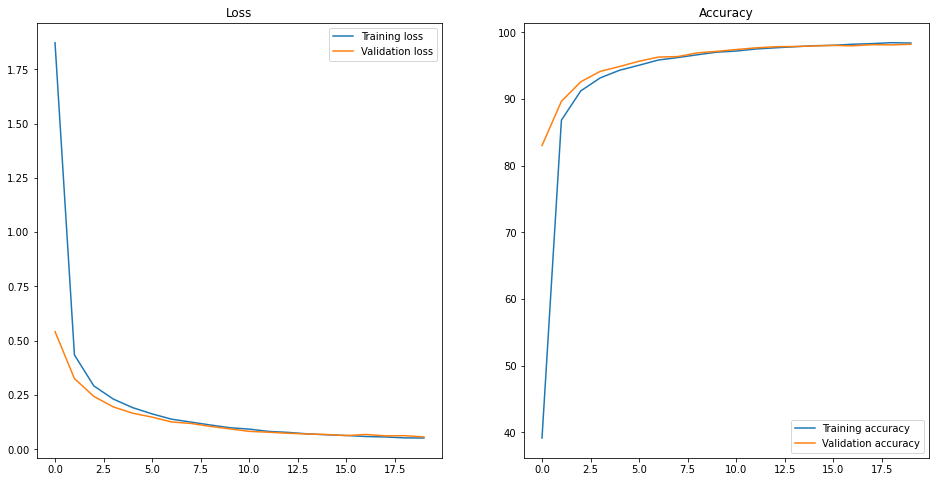

In [19]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in train_acc], label='Training accuracy')
plt.plot([x.cpu() for x in valid_acc], label='Validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show

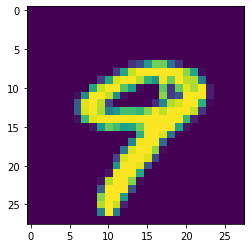

In [20]:
if torch.cuda.is_available():
    net = net.cuda()
else: net=net.cpu()

image_index = 9
img = mnist_val[image_index][0].view((1, 1, 28, 28))
label = mnist_val[image_index][1]
plt.imshow(img[0,0])
plt.show()
net.eval()
if torch.cuda.is_available:
    img = img.cpu()
output = net(img)

In [17]:
output

tensor([[ -5.4971, -14.2376,  -4.5644,   1.7312,   2.8372,  -2.2554, -11.8152,
           6.6830,   3.5353,  12.9458]], grad_fn=<AddmmBackward0>)

In [18]:
torch.max(output, 1)

torch.return_types.max(
values=tensor([12.9458], grad_fn=<MaxBackward0>),
indices=tensor([9]))

## Exercise 22!

Try the same thing with cats and dogs!

https://www.kaggle.com/c/dogs-vs-cats
